In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [30]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
data_dir = os.getenv('HOME')+'/aiffel/Datathon'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/Datathon/train.csv
/aiffel/aiffel/Datathon/test.csv


In [14]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (1459, 11)
test data dim : (715, 10)


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [16]:
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [10]:
test.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020,36.0,28.0
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027,52.0,38.0
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041,18.0,15.0


In [17]:
train.isnull().sum() # 결측치 확인

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

train DATA 에서 결측치가 존재하는 곳을 확인

In [32]:
train[train['hour_bef_temperature'].isna()] # train결측치가 있는 행을 확인

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
934,1420,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [33]:
train.groupby('hour').mean()['hour_bef_temperature'] # 'hour_bef_temperature'열의 시간대별 평균을 계산

hour
0     14.788136
1     14.155738
2     13.747541
3     13.357377
4     13.001639
5     12.673770
6     12.377049
7     12.191803
8     12.600000
9     14.318033
10    16.242623
11    18.019672
12    19.457377
13    20.648333
14    21.234426
15    21.744262
16    22.015000
17    21.603333
18    20.926667
19    19.704918
20    18.191803
21    16.978333
22    16.063934
23    15.418033
Name: hour_bef_temperature, dtype: float64

In [35]:
train['hour_bef_temperature'].fillna({934:14.788136, 1035:20.926667}, inplace=True) # 결측치에, 시간대별 평균값을 대치
train.loc[[934, 1035], :] # 해당위치에 결측치가 채워졌는지 확인

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
934,1420,0,14.788136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,20.926667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [39]:
train[train['hour_bef_windspeed'].isna()] # 결측치가 있는지 확인

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count


In [37]:
train.groupby('hour').mean()['hour_bef_windspeed'] # 'hour_bef_windspeed'열의 시간대별 평균을 계산

hour
0     1.965517
1     1.836667
2     1.633333
3     1.620000
4     1.409836
5     1.296721
6     1.331148
7     1.262295
8     1.632787
9     1.829508
10    2.122951
11    2.485246
12    2.766667
13    3.281356
14    3.522951
15    3.768852
16    3.820000
17    3.801667
18    3.838333
19    3.595082
20    3.278333
21    2.755000
22    2.498361
23    2.195082
Name: hour_bef_windspeed, dtype: float64

In [38]:
# 'hour_bef_windspeed' 결측치에 시간대별 평균값을 대치

train['hour_bef_windspeed'].fillna({18:3.281356, 244:1.836667, 260:1.620000, 376:1.965517, 780:3.278333, 934:1.965517, 1035:3.838333, 1138:2.766667, 1229:1.633333}, inplace=True)

In [18]:
test.isnull().sum()

id                         0
hour                       0
hour_bef_temperature       1
hour_bef_precipitation     1
hour_bef_windspeed         1
hour_bef_humidity          1
hour_bef_visibility        1
hour_bef_ozone            35
hour_bef_pm10             37
hour_bef_pm2.5            36
dtype: int64

In [41]:
test[test['hour_bef_temperature'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
653,1943,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
test['hour_bef_temperature'].fillna({653:19.704918}, inplace=True)

In [46]:
test[test['hour_bef_windspeed'].isna()] # 결측치가 있는지 확인

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
653,1943,19,19.704918,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
test['hour_bef_windspeed'].fillna(3.595082, inplace=True) # 결측치를 해당시간대 평균값으로 대치

In [53]:
test.isna().sum() # 결측치가 있는지 확인

id                         0
hour                       0
hour_bef_temperature       0
hour_bef_precipitation     1
hour_bef_windspeed         0
hour_bef_humidity          1
hour_bef_visibility        1
hour_bef_ozone            35
hour_bef_pm10             37
hour_bef_pm2.5            36
dtype: int64

In [54]:
train.fillna(0,inplace = True) 
test.fillna(0,inplace = True)

In [55]:
train_x = train.drop(['count'],axis = 1)
train_y = train['count']

In [57]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

In [58]:
model=RandomForestRegressor(n_estimators=100)
model.fit(train_x,train_y)

RandomForestRegressor()

In [59]:
pred = model.predict(test)

In [61]:
submission = pd.read_csv('/aiffel/aiffel/Datathon/submission.csv')
submission

,id,count
0,0,NaN
1,1,NaN
2,2,NaN
3,4,NaN
4,5,NaN
...,...,...
710,2148,NaN
711,2149,NaN
712,2165,NaN
713,2166,NaN


In [62]:
submission['count'] = pred

In [63]:
submission

,id,count
0,0,91.76
1,1,234.41
2,2,100.34
3,4,29.84
4,5,62.65
...,...,...
710,2148,53.13
711,2149,67.80
712,2165,127.40
713,2166,171.98


In [64]:
submission.to_csv('1st.csv',index = False)

In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1459 non-null   float64
 3   hour_bef_precipitation  1459 non-null   float64
 4   hour_bef_windspeed      1459 non-null   float64
 5   hour_bef_humidity       1459 non-null   float64
 6   hour_bef_visibility     1459 non-null   float64
 7   hour_bef_ozone          1459 non-null   float64
 8   hour_bef_pm10           1459 non-null   float64
 9   hour_bef_pm2.5          1459 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


### DACON홈페이지에서 올려놓은 동영상대로, 온도와 풍속을 시간별평균으로 대치.

### 모델은 RandomForest로 동일.

### 점수는 46.16643(872위)

In [19]:
train.describe()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
count,1459.000000,1459.000000,1457.000000,1457.000000,1450.000000,1457.000000,1457.000000,1383.000000,1369.000000,1342.000000,1459.000000
mean,1105.914325,11.493489,16.717433,0.031572,2.479034,52.231297,1405.216884,0.039149,57.168736,30.327124,108.563400
std,631.338681,6.922790,5.239150,0.174917,1.378265,20.370387,583.131708,0.019509,31.771019,14.713252,82.631733
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,555.500000,5.500000,12.800000,0.000000,1.400000,36.000000,879.000000,0.025500,36.000000,20.000000,37.000000
50%,1115.000000,11.000000,16.600000,0.000000,2.300000,51.000000,1577.000000,0.039000,51.000000,26.000000,96.000000
75%,1651.000000,17.500000,20.100000,0.000000,3.400000,69.000000,1994.000000,0.052000,69.000000,37.000000,150.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


In [22]:
train.sort_values(by=['hour']).head(50)

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
149,223,0,18.6,0.0,0.3,58.0,554.0,0.053,110.0,63.0,104.0
485,748,0,14.8,0.0,1.2,64.0,2000.0,0.042,28.0,16.0,78.0
1224,1847,0,16.8,0.0,0.6,62.0,2000.0,0.029,35.0,19.0,94.0
829,1260,0,15.6,0.0,2.3,62.0,1433.0,0.023,56.0,36.0,93.0
473,729,0,13.8,0.0,3.2,69.0,518.0,0.042,79.0,46.0,46.0
544,837,0,12.4,0.0,2.6,55.0,965.0,0.059,81.0,54.0,51.0
681,1039,0,14.4,0.0,3.0,75.0,1629.0,0.022,32.0,20.0,67.0
756,1157,0,9.0,0.0,2.6,52.0,2000.0,0.034,57.0,21.0,44.0
650,994,0,17.6,0.0,1.2,73.0,665.0,0.038,57.0,36.0,80.0
976,1477,0,5.9,0.0,2.0,74.0,2000.0,0.042,25.0,25.0,40.0


<AxesSubplot:xlabel='hour', ylabel='hour_bef_humidity'>

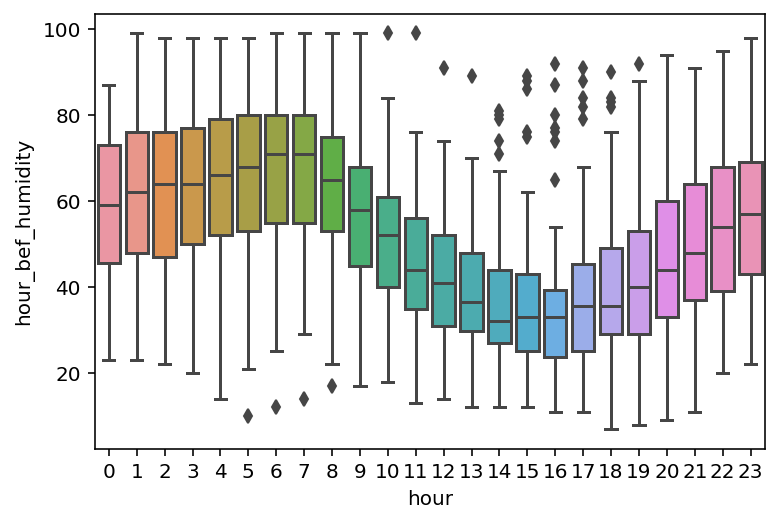

In [25]:
sns.boxplot(x = 'hour', y = 'hour_bef_humidity', data = train)

 fig, ax = plt.subplots(5, 2, figsize=(15, 25))

 count = 1
 columns = train.columns
 for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 11 :
        break